## Definitions

In [1]:
## Imports

import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import time
from tqdm import tqdm
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import MultipleLocator

from statsmodels.stats.weightstats import DescrStatsW

In [2]:
## Set plot styles

%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

In [3]:
#######################
## Define your parameters here:
# path with Gator files, e.g. '/home/alex/PhD/Gator/XLZD_PMTs_R11410-20_8x_20240827/'
path = '/home/alex/PhD/Gator/Data/PMTs_long_holders*/' 
# filename patter in folder given above, e.g 'XLZD_PMTs_R11410-20_8x_20240827*'
filename_patter = 'PMTs_long_holders*' 
# calibration to be used
calibration_name = '2024.07' 
#######################

In [4]:
files_list = glob.glob(path+filename_patter) 
files_list

['/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_4_043.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_4_019.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_0_001.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_0_006.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_4_107.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_4_032.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_0_004.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_4_106.SPE',
 '/home/alex/PhD/Gator/Data/PMTs_long_holders_2units_bkgd/PMTs_long_holders_2units_bkgd_20241107_4_146.SPE',
 '/home/alex/PhD/Ga

In [5]:
number_SPE_files = 0
number_txt_files = 0
for el in files_list:
    if (el.find('.SPE') > -1) and ((files_list[0]).find('.SPE2') < 0):
        number_SPE_files += 1
    elif el.find('.txt') > -1:
        number_txt_files += 1
if number_SPE_files > 0:
    file_type = 'SPE'
    print('Assume .SPE file format')
elif number_txt_files > 0:
    file_type = 'txt'
    print('Assume .txt file format')
else:
    raise ValueError('Could not determine file format (SPE or txt).')

Assume .SPE file format


In [6]:
## Gator detector mass
mass = 2.2

In [7]:
def load_file_txt(file):
    number_lines_header = 4 ## There are 4 lines in the txt file before the spectrum data
    
    df = pd.read_csv(file, delimiter = "\t", header=None, names=['channel', 'counts'], skiprows=np.arange(number_lines_header))
    #df.astype({'channel': 'int'})
    df['channel'] = df['channel']-3
    
    with open(file) as fp:
        string_time_in = file[file.find('.txt')-15:file.find('.txt')]
        string_time = string_time_in[4:5+1]+'/'+string_time_in[6:7+1]+'/'+string_time_in[0:3+1]+' '+string_time_in[9:10+1]+':'+string_time_in[11:12+1]+':'+string_time_in[13:14+1]
        #print(string_time)
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 0: ## description of the sample
                descr = line
                #print(descr)
            elif i == 1: ## acquisition time
                live_time = int(line) ## acquisition live time in seconds (without dead time)
                #print(live_time)
    
    return df, live_time, string_time, descr

def load_file(file):
    number_lines_header = 12 ## There are 12 header lines in the SPE file
    counts_list = []

    with open(file) as fp:
        for i, line in enumerate(fp):
            line = line.rstrip('\n')
            if i == 1: ## description of the sample
                descr = line
                #print(descr)
            elif i == 7: ## starting acquisition time
                string_time = line
                #print(string_time)
                # TODO: convert to UNIX time
            elif i == 9: ## acquisition time
                live_time = int(line.split(' ')[0]) ## acquisition live time in seconds (without dead time)
                real_time = int(line.split(' ')[1]) ## acquisition real time in seconds
                #print(live_time, real_time)
            elif i == 11: ## channel numbers
                first_channel = int(line.split(' ')[0]) ## number of first channel, usually 0
                last_channel = int(line.split(' ')[1]) ## number of last channel, usually 16383 (= 2^14-1)
                #print(first_channel, last_channel)
            elif (i >= number_lines_header):
                if (i<=last_channel+number_lines_header):
                    counts_list.append(int(line))
                elif i > last_channel+number_lines_header:
                    break

    channels_list = np.arange(0, last_channel+1)
    df = pd.DataFrame(data={'channel': channels_list, 'counts': counts_list})
    
    return df, live_time, string_time, descr

In [8]:
## Energy calibrations 

cal_202407_CE_a = 0.16395071397817926
cal_202407_CE_b = 0.6649302765158444
cal_202407_CE = (cal_202407_CE_a, cal_202407_CE_b)
cal_202407_EC_a = 1/cal_202407_CE_a
cal_202407_EC_b = -cal_202407_CE_b/cal_202407_CE_a
cal_202407_EC = (cal_202407_EC_a, cal_202407_EC_b)

def func_e_to_adc(x = np.array([100, 2700]), a = cal_202407_CE_a, b = cal_202407_CE_b):
    res = a*x+b
    res = np.minimum(res, 16376)
    res = np.maximum(res, 0)
    return res

## Trigger rate in energy region [e_low, e_high]

def load_files_202407(files_list, e_low = 100, e_high = 2700):
    calib1_adcrange = func_e_to_adc(np.array([e_low, e_high]), cal_202407_EC_a, cal_202407_EC_b)  
    countssum_list = []
    live_time_list = []
    string_time_list = []
    descr_list = []
    file_string_list = []
    for i_file, file in tqdm(enumerate(files_list)):
        df_counts, live_time, string_time, descr = load_file(file)
        countssum_list.append(((df_counts.loc[int(np.floor(calib1_adcrange[0]))].counts) * (int(np.ceil(calib1_adcrange[0]))-calib1_adcrange[0])) + np.sum((df_counts.loc[int(np.ceil(calib1_adcrange[0])) : int(np.floor(calib1_adcrange[1]))]).counts) + ((df_counts.loc[int(np.ceil(calib1_adcrange[1]))].counts) * (calib1_adcrange[1]-int(np.floor(calib1_adcrange[1])))))
        live_time_list.append(live_time)
        string_time_list.append(string_time)
        descr_list.append(descr)
        file_string_list.append(file[file.rfind('/')+1:])
    
    df_combined = pd.DataFrame(data={'countssum': countssum_list, 
                                     'live_time': live_time_list, 'string_time': string_time_list,  'descr': descr_list, 
                                     'file_string': file_string_list})
    df_combined['timestamp'] = [int(datetime.strptime(s, "%m/%d/%Y %H:%M:%S").timestamp()) for s in df_combined.string_time]
    df_combined['timestamp_mid'] = df_combined['timestamp'] + df_combined['live_time']/2
    df_combined = df_combined.sort_values('timestamp')
    df_combined = df_combined.reset_index(drop=True)
    df_combined['trigrate'] = df_combined.countssum / df_combined.live_time ## trigger rate in 1/s
    df_combined['trigrate_err'] = np.sqrt(df_combined.countssum) / df_combined.live_time
    
    df_combined = df_combined.sort_values(by=['timestamp'])
    df_combined = df_combined.reset_index(drop=True)
    
    return df_combined

# Load Data

In [9]:
## Energy range for trigger rate to be plotted
e_low  =   10
e_high =  100

In [10]:
def load_df(files_list, e_low = e_low, e_high = e_high):
    if file_type == 'SPE':
        if calibration_name == '2024.07':
            df = load_files_202407(files_list, e_low = e_low, e_high = e_high)
        else:
            raise ValueError('Calibration not implemented for SPE files.')
    elif file_type == 'txt':
        raise ValueError('Calibration not implemented for txt files.')
    return df

df = load_df(files_list, e_low = e_low, e_high = e_high)
df

354it [00:03, 100.34it/s]


,countssum,live_time,string_time,descr,file_string,timestamp,timestamp_mid,trigrate,trigrate_err
0,87612.0,14400,11/07/2024 17:32:04,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_000.SPE,1730997124,1.731004e+09,6.084167,0.020555
1,22.0,14400,11/07/2024 21:32:16,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_001.SPE,1731011536,1.731019e+09,0.001528,0.000326
2,15.0,14400,11/08/2024 01:32:22,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_002.SPE,1731025942,1.731033e+09,0.001042,0.000269
3,22.0,14400,11/08/2024 05:32:28,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_003.SPE,1731040348,1.731048e+09,0.001528,0.000326
4,16.0,14400,11/08/2024 09:32:34,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_004.SPE,1731054754,1.731062e+09,0.001111,0.000278
...,...,...,...,...,...,...,...,...,...
349,17.0,14400,01/06/2025 15:35:01,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_163.SPE,1736174101,1.736181e+09,0.001181,0.000286
350,18.0,14400,01/06/2025 19:35:07,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_164.SPE,1736188507,1.736196e+09,0.001250,0.000295
351,18.0,14400,01/06/2025 23:35:13,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_165.SPE,1736202913,1.736210e+09,0.001250,0.000295
352,18.0,14400,01/07/2025 03:35:19,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_166.SPE,1736217319,1.736225e+09,0.001250,0.000295


# Analysis

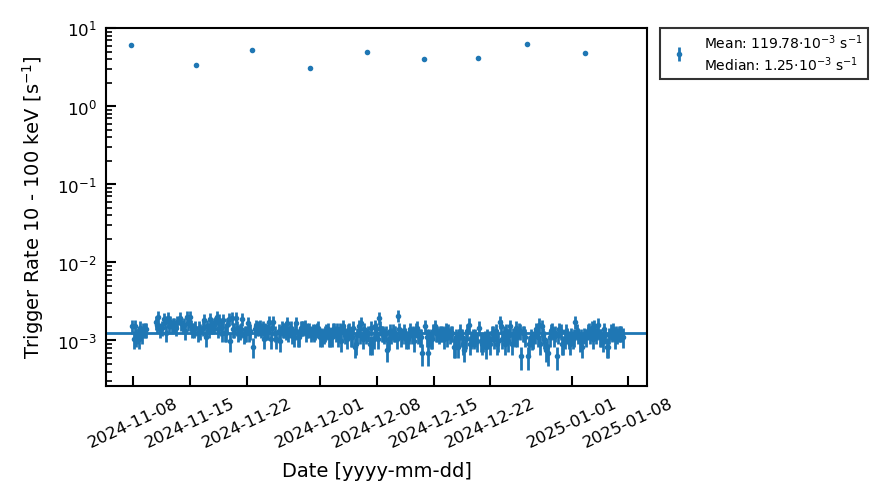

In [11]:
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

## 2019:
mean_trigrate = np.mean(df.trigrate)
std_trigrate = np.std(df.trigrate)
std_red_trigrate = std_trigrate/np.sqrt(len(df.trigrate)-1)
median_trigrate = np.median(df.trigrate)
plt.errorbar([datetime.fromtimestamp(d) for d in df.timestamp], df.trigrate, yerr=df.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='C0', label='Mean: '+
             str(round(1e3*mean_trigrate,2))+'$\cdot10^{-3}$ s$^{-1}$'+'\nMedian: '+ 
             str(round(1e3*median_trigrate,2))+'$\cdot10^{-3}$ s$^{-1}$')
plt.axhline(y=median_trigrate, linewidth=1, color = 'C0')

plt.xlabel(r'Date [yyyy-mm-dd]')
plt.ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]')
plt.xticks(rotation=25)

#plt.ylim(0.0014, 0.0039)

if e_high <= 100:
    plt.yscale('log')

legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.show()

## Remove data near dewar refills

In [12]:
## Load levelmeter data during runs
def load_levelmeter_file(filename, h = 1/6):
    df_level_tmp = pd.read_csv(filename, delimiter = "\t", header=None, names=['levelmeter_value', 'timestamp'])

    if df_level_tmp.timestamp[0] > 1292439600:
        df_level_tmp['levelmeter_level'] = 6.82 * df_level_tmp.levelmeter_value - 1027.3
    else:
        df_level_tmp['levelmeter_level'] = 3.46 * df_level_tmp.levelmeter_value - 519.36

    i = 0
    levelmeter_value_mean_list = []
    levelmeter_value_std_list = []
    levelmeter_value_max_list = []
    levelmeter_value_min_list = []
    levelmeter_level_mean_list = []
    levelmeter_level_std_list = []
    levelmeter_level_max_list = []
    levelmeter_level_min_list = []
    timestamp_mean_list = []
    timestamp_std_list = []
    timestamp_max_list = []
    timestamp_min_list = []

    while True:
        ts_min = df_level_tmp.timestamp[0] + h*3600 * i
        ts_max = ts_min + h*3600

        df_level_tmp_sel = df_level_tmp[(df_level_tmp. timestamp >= ts_min) & (df_level_tmp. timestamp < ts_max)]
        if len(df_level_tmp_sel)<6:
            break
        #print(i)

        levelmeter_value_mean_list.append(np.mean(df_level_tmp_sel.levelmeter_value))
        levelmeter_value_std_list.append(np.std(df_level_tmp_sel.levelmeter_value, ddof=1))
        levelmeter_value_max_list.append(np.max(df_level_tmp_sel.levelmeter_value))
        levelmeter_value_min_list.append(np.min(df_level_tmp_sel.levelmeter_value))
        levelmeter_level_mean_list.append(np.mean(df_level_tmp_sel.levelmeter_level))
        levelmeter_level_std_list.append(np.std(df_level_tmp_sel.levelmeter_level, ddof=1))
        levelmeter_level_max_list.append(np.max(df_level_tmp_sel.levelmeter_level))
        levelmeter_level_min_list.append(np.min(df_level_tmp_sel.levelmeter_level))
        timestamp_mean_list.append(np.mean(df_level_tmp_sel.timestamp))
        timestamp_std_list.append(np.std(df_level_tmp_sel.timestamp, ddof=1))
        timestamp_max_list.append(np.max(df_level_tmp_sel.timestamp))
        timestamp_min_list.append(np.min(df_level_tmp_sel.timestamp))

        i += 1

    df_level_tmp = pd.DataFrame(data={
        'levelmeter_value_mean': levelmeter_value_mean_list, 'levelmeter_value_std': levelmeter_value_std_list,
        'levelmeter_value_max': levelmeter_value_max_list, 'levelmeter_value_min': levelmeter_value_min_list, 
        'levelmeter_level_mean': levelmeter_level_mean_list, 'levelmeter_level_std': levelmeter_level_std_list,
        'levelmeter_level_max': levelmeter_level_max_list, 'levelmeter_level_min': levelmeter_level_min_list, 
        'timestamp_mean': timestamp_mean_list, 'timestamp_std': timestamp_std_list,
        'timestamp_max': timestamp_max_list, 'timestamp_min': timestamp_min_list})
    
    return df_level_tmp

In [13]:
path_level = '/home/alex/PhD/Gator/Data/SC/levelmeter/'
files_list_level_ts_pre_list = np.arange(int(np.floor(np.min(df.timestamp)/1e9*1000)), 
          int(np.ceil((np.max(df.timestamp) + np.max(np.diff(df.timestamp)))/1e9*1000))+1)
#files_list_level = glob.glob(path_level+'levelmeter16*')
for i, el in enumerate(files_list_level_ts_pre_list):
    if i == 0:
        files_list_level = glob.glob(path_level+'levelmeter'+str(el)+'*')
    else:
        files_list_level = files_list_level+glob.glob(path_level+'levelmeter'+str(el)+'*')
files_list_level.sort()
print(len(files_list_level))
files_list_level

73


['/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730022593.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730109014.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730195450.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730281902.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730368306.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730454727.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730541147.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730627552.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730713972.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1730800393.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1731148731.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1731235187.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1731321642.txt',
 '/home/alex/PhD/Gator/Data/SC/levelmeter/levelmeter1731408052.txt',
 '/home/alex/PhD/Gator/Data/SC/lev

In [14]:
def load_levelmeter_files(files_list = files_list_level):
    for i, file in tqdm(enumerate(files_list)):
        if i > 0:
            df_level = pd.concat([df_level, load_levelmeter_file(file)], ignore_index=True)
        else:
            df_level = load_levelmeter_file(file)
    return df_level

df_level = load_levelmeter_files()
df_level

73it [00:11,  6.40it/s]


,levelmeter_value_mean,levelmeter_value_std,levelmeter_value_max,levelmeter_value_min,levelmeter_level_mean,levelmeter_level_std,levelmeter_level_max,levelmeter_level_min,timestamp_mean,timestamp_std,timestamp_max,timestamp_min
0,153.186520,0.000779,153.187834,153.185063,17.432068,0.005315,17.441027,17.422132,1.730023e+09,188.173236,1.730023e+09,1.730023e+09
1,153.185509,0.001314,153.187802,153.183224,17.425174,0.008964,17.440807,17.409585,1.730023e+09,188.265061,1.730024e+09,1.730023e+09
2,153.183610,0.001579,153.185020,153.180507,17.412218,0.010766,17.421839,17.391059,1.730024e+09,170.205023,1.730024e+09,1.730024e+09
3,153.182923,0.001147,153.184133,153.181362,17.407534,0.007822,17.415785,17.396891,1.730025e+09,188.154901,1.730025e+09,1.730024e+09
4,153.181632,0.000963,153.183170,153.179533,17.398729,0.006568,17.409218,17.384417,1.730025e+09,188.265061,1.730026e+09,1.730025e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
9714,152.654876,0.001677,152.656512,152.651056,13.806253,0.011436,13.817412,13.780201,1.736252e+09,170.113769,1.736252e+09,1.736252e+09
9715,152.653035,0.002069,152.656651,152.650346,13.793699,0.014114,13.818360,13.775360,1.736252e+09,188.099885,1.736253e+09,1.736252e+09
9716,152.652403,0.001362,152.654159,152.650513,13.789389,0.009289,13.801366,13.776500,1.736253e+09,188.099885,1.736253e+09,1.736253e+09
9717,152.650558,0.001635,152.652434,152.647939,13.776806,0.011148,13.789597,13.758943,1.736254e+09,170.205023,1.736254e+09,1.736253e+09


In [15]:
df_level_sel  = df_level[(df_level.timestamp_max >= np.array(df.timestamp)[0]) & (df_level.timestamp_min <= np.array(df.timestamp)[-1])]

In [16]:
def merge_overlapping_tuples(temp_tuple):
    temp_tuple.sort(key=lambda interval: interval[0])
    merged = [temp_tuple[0]]
    for current in temp_tuple:
        previous = merged[-1]
        if current[0] <= previous[1]:
            previous[1] = max(previous[1], current[1])
        else:
            merged.append(current)
    return merged

In [17]:
## calculate magnitude 'derivative' of temperature in cm/min
deriv_abs = np.abs(np.diff(df_level_sel.levelmeter_level_mean)/np.diff(df_level_sel.timestamp_mean)*60)
deriv_abs_med = np.median(deriv_abs)
## set threshold for 'significant' level change
#deriv_abs_thr = 20 * deriv_abs_med
deriv_abs_thr = 10 * deriv_abs_med

## find timestamps with excess in derivative
deriv_abs_excess_list = (np.array(df_level_sel.timestamp_mean)[1:])[deriv_abs > deriv_abs_thr]
## define time period tuples with +- margin(s)
#deriv_abs_excess_list = np.array([deriv_abs_excess_list-1*3600, deriv_abs_excess_list+1*3600]).T
deriv_abs_excess_list = np.array([deriv_abs_excess_list-1.5*1*3600, deriv_abs_excess_list+1.5*1*3600]).T
deriv_abs_excess_list = deriv_abs_excess_list.tolist()
## merge overlapping intervals
deriv_abs_excess_list = merge_overlapping_tuples(deriv_abs_excess_list)
print('Number determined refill periods: '+str(len(deriv_abs_excess_list)))

Number determined refill periods: 17


In [18]:
## Determine and output "dirty" files, i.e. close to refill time

def find_dirty_runs(df=df):
    runs_periods = np.array([df.timestamp, 
              df.timestamp + np.append(np.diff(df.timestamp), np.diff(df.timestamp)[-1])]).T

    dirty_runs_periods = []
    for el_runs_periods in runs_periods:
        for el_deriv_abs_excess_list in deriv_abs_excess_list:
            if(el_runs_periods[1]>= el_deriv_abs_excess_list[0] 
               and el_runs_periods[0]<= el_deriv_abs_excess_list[1]):
                dirty_runs_periods.append(el_runs_periods)
    dirty_runs_periods = np.array(dirty_runs_periods)
    dirty_runs_periods = np.unique(dirty_runs_periods, axis = 0)
    dirty_runs_timestamp = dirty_runs_periods[:,0]

    dirty_runs_filename_name = 'list'

    if (e_low == 10) & (e_high == 100):
        df['clean'] = [(ts not in dirty_runs_timestamp) for ts in df.timestamp]
        df['clean'] = np.logical_or(df['clean'], df.trigrate < 5*np.median(df.trigrate))
        dirty_runs_filename = (df[~df.clean]).file_string.tolist()
        print('Write filenames "dirty runs" '+dirty_runs_filename_name+' to file '+'dirty_runs_filename_'+dirty_runs_filename_name+'.txt')
        with open('dirty_runs_filename_'+dirty_runs_filename_name+'.txt', 'w') as f:
            for item in dirty_runs_filename:
                f.write("%s\n" % item)    
    else:
        print('Read dirty_runs_filename_'+dirty_runs_filename_name+' from file '+'dirty_runs_filename_'+dirty_runs_filename_name+'.txt')
        with open('dirty_runs_filename_'+dirty_runs_filename_name+'.txt', 'r') as f:
            dirty_runs_filename = f.read().splitlines()    
        df['clean'] = [(ts not in dirty_runs_filename) for ts in df.file_string]
        dirty_runs_filename = (df[~df.clean]).file_string.tolist()
        
    print('Number "dirty" files: '+str(len(dirty_runs_filename)))
        
    return df, dirty_runs_filename

df, dirty_runs_filename = find_dirty_runs(df=df)

Write filenames "dirty runs" list to file dirty_runs_filename_list.txt
Number "dirty" files: 8


In [19]:
# Manually remove first few data points

thr_i_loading = 0 # set to -1 to disable, set to 0 to only remove first data point

if thr_i_loading >= 0:
    for el in df.file_string[0:thr_i_loading+1]:
        if el not in dirty_runs_filename:
            dirty_runs_filename.append(el)
dirty_runs_filename.sort()

df['clean'] = [(ts not in dirty_runs_filename) for ts in df.file_string]
dirty_runs_filename_name = 'list'
with open('dirty_runs_filename_'+dirty_runs_filename_name+'.txt', 'w') as f:
    for item in dirty_runs_filename:
        f.write("%s\n" % item)
print('Number "dirty" files: '+str(len(dirty_runs_filename)))

Number "dirty" files: 9


In [20]:
# Print "dirty" files, i.e. close to refill time
for el in dirty_runs_filename:
    print(el)

PMTs_long_holders_2units_bkgd_20241107_0_000.SPE
PMTs_long_holders_2units_bkgd_20241107_4_012.SPE
PMTs_long_holders_2units_bkgd_20241107_4_053.SPE
PMTs_long_holders_2units_bkgd_20241107_4_096.SPE
PMTs_long_holders_2units_bkgd_20241107_4_138.SPE
PMTs_long_holders_3units_bkgd_20241210_0_020.SPE
PMTs_long_holders_3units_bkgd_20241210_0_060.SPE
PMTs_long_holders_3units_bkgd_20241210_0_096.SPE
PMTs_long_holders_3units_bkgd_20241210_0_139.SPE


In [21]:
df

,countssum,live_time,string_time,descr,file_string,timestamp,timestamp_mid,trigrate,trigrate_err,clean
0,87612.0,14400,11/07/2024 17:32:04,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_000.SPE,1730997124,1.731004e+09,6.084167,0.020555,False
1,22.0,14400,11/07/2024 21:32:16,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_001.SPE,1731011536,1.731019e+09,0.001528,0.000326,True
2,15.0,14400,11/08/2024 01:32:22,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_002.SPE,1731025942,1.731033e+09,0.001042,0.000269,True
3,22.0,14400,11/08/2024 05:32:28,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_003.SPE,1731040348,1.731048e+09,0.001528,0.000326,True
4,16.0,14400,11/08/2024 09:32:34,PMTs long holders background (2 units),PMTs_long_holders_2units_bkgd_20241107_0_004.SPE,1731054754,1.731062e+09,0.001111,0.000278,True
...,...,...,...,...,...,...,...,...,...,...
349,17.0,14400,01/06/2025 15:35:01,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_163.SPE,1736174101,1.736181e+09,0.001181,0.000286,True
350,18.0,14400,01/06/2025 19:35:07,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_164.SPE,1736188507,1.736196e+09,0.001250,0.000295,True
351,18.0,14400,01/06/2025 23:35:13,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_165.SPE,1736202913,1.736210e+09,0.001250,0.000295,True
352,18.0,14400,01/07/2025 03:35:19,PMTs_long_holders_3units_bkgd_20241210,PMTs_long_holders_3units_bkgd_20241210_0_166.SPE,1736217319,1.736225e+09,0.001250,0.000295,True


In [22]:
df_clean = df[df.clean]

weighted_stats_clean = DescrStatsW(df_clean.trigrate, weights=df_clean.live_time/np.sum(df_clean.live_time)*len(df_clean.trigrate), ddof=0)
weighted_mean_clean = weighted_stats_clean.mean
weighted_std_clean = weighted_stats_clean.std
weighted_stdmean_clean = weighted_stats_clean.std_mean

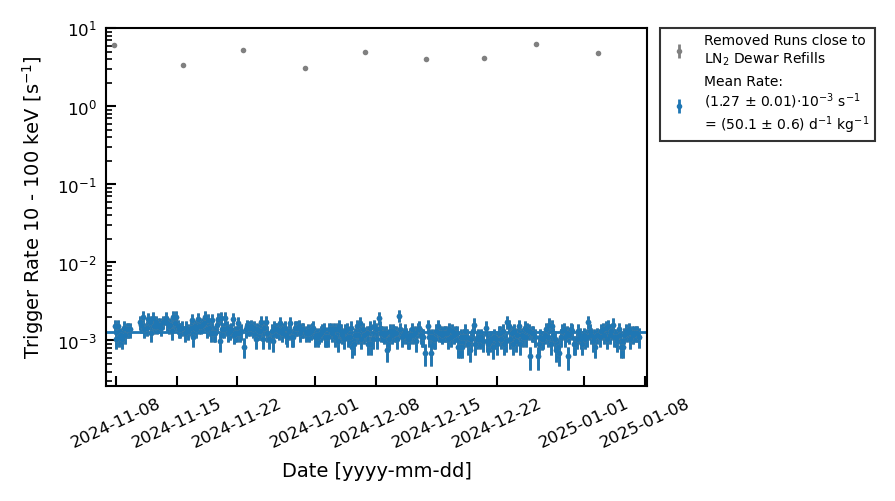

In [23]:
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

mean_trigrate = weighted_mean_clean
std_trigrate = weighted_std_clean
std_trigrate_red = weighted_stdmean_clean
plt.errorbar([datetime.fromtimestamp(d) for d in df.timestamp], df.trigrate, yerr=df.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='gray', 
            label = 'Removed Runs close to\nLN$_2$ Dewar Refills')
plt.errorbar([datetime.fromtimestamp(d) for d in df_clean.timestamp], df_clean.trigrate, yerr=df_clean.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='C0', label='Mean Rate:\n('+ 
             str(round(1e3*mean_trigrate,2))+' ± '+
             str(round(1e3*std_trigrate_red,2))+')$\cdot10^{-3}$ s$^{-1}$'+
             '\n= ('+str(round(24*3600*mean_trigrate/mass,1))+' ± '+
             str(round(24*3600*std_trigrate_red/mass,1))+') d$^{-1}$ kg$^{-1}$')
plt.axhline(y=mean_trigrate, linewidth=1, color = 'C0')

plt.xlabel(r'Date [yyyy-mm-dd]')
plt.ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]')
plt.xticks(rotation=25)

#plt.ylim(0.0014, 0.0039)
plt.xlim(left = datetime.fromtimestamp(min(np.array(df_clean.timestamp)-2*12*3600)))
plt.xlim(right = datetime.fromtimestamp(max(np.array(df_clean.timestamp)+2*12*3600)))

if e_high <= 100:
    plt.yscale('log')

legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.show()

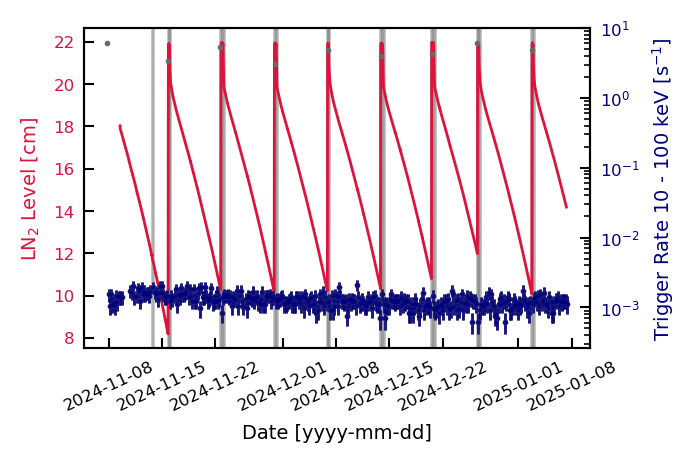

In [24]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date [yyyy-mm-dd]')
ax1.tick_params(axis='x', rotation=25)

color = 'crimson'
ax1.set_ylabel('LN$_2$ Level [cm]', color=color)
ax1.plot([datetime.fromtimestamp(d) for d in df_level_sel.timestamp_mean], 
         df_level_sel.levelmeter_level_mean, color=color, linewidth=1, alpha = 1)
ax1.tick_params(axis='y', labelcolor=color)

for el in deriv_abs_excess_list:
    ax1.axvspan(datetime.fromtimestamp(el[0]), datetime.fromtimestamp(el[1]), 
                alpha=0.5, color='gray', zorder = -2)

ax2 = ax1.twinx()
ax2.errorbar([datetime.fromtimestamp(d) for d in df.timestamp_mid], df.trigrate, yerr=df.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='dimgray', 
            label = 'Removed Runs close to\nLN$_2$ Dewar Refills')
color = 'navy'
ax2.set_ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]', color=color)
ax2.errorbar(np.array([datetime.fromtimestamp(d) for d in df_clean.timestamp_mid]), 
             np.array(df_clean.trigrate), yerr=np.array(df_clean.trigrate_err), 
             fmt='o',ms=1, linewidth=1, color='navy', alpha = 0.8)
ax2.tick_params(axis='y', labelcolor=color)

if e_high <= 100:
    ax2.set_yscale('log')

fig.tight_layout()
plt.savefig('trigrate_10_100_ln2level.png', bbox_inches='tight')

plt.show()

In [25]:
print(np.sum(df_clean.live_time)/np.sum(df.live_time))
print(1-np.sum(df_clean.live_time)/np.sum(df.live_time))

0.9745578344005563
0.025442165599443678


In [26]:
e_low  =   100
e_high =  2700

df_plot = load_df(files_list, e_low = e_low, e_high = e_high)
df_plot, dirty_runs_filename = find_dirty_runs(df=df_plot)
df_plot_clean = df_plot[df_plot.clean]

weighted_stats_plot_clean = DescrStatsW(df_plot_clean.trigrate, weights=df_plot_clean.live_time/np.sum(df_plot_clean.live_time)*len(df_plot_clean.trigrate), ddof=0)
weighted_mean_plot_clean = weighted_stats_plot_clean.mean
weighted_std_plot_clean = weighted_stats_plot_clean.std
weighted_stdmean_plot_clean = weighted_stats_plot_clean.std_mean

354it [00:03, 102.21it/s]

Read dirty_runs_filename_list from file dirty_runs_filename_list.txt
Number "dirty" files: 9


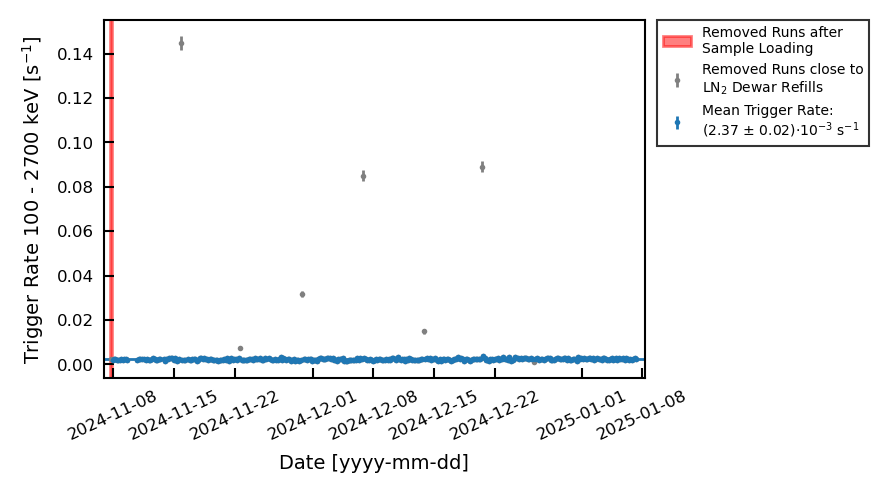

In [27]:
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

mean_trigrate = weighted_mean_plot_clean
std_trigrate = weighted_std_plot_clean
std_trigrate_red = weighted_stdmean_plot_clean
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot.timestamp], df_plot.trigrate, yerr=df_plot.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='gray', 
            label = 'Removed Runs close to\nLN$_2$ Dewar Refills')
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot_clean.timestamp], df_plot_clean.trigrate, yerr=df_plot_clean.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='C0', label='Mean Trigger Rate:\n('+ 
             str(round(1e3*mean_trigrate,2))+' ± '+
             str(round(1e3*std_trigrate_red,2))+')$\cdot10^{-3}$ s$^{-1}$')
plt.axhline(y=mean_trigrate, linewidth=1, color = 'C0')

plt.xlabel(r'Date [yyyy-mm-dd]')
plt.ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]')
plt.xticks(rotation=25)

#plt.ylim(0.0014, 0.0039)
plt.xlim(left = datetime.fromtimestamp(min(np.array(df_plot_clean.timestamp)-2*12*3600)))
plt.xlim(right = datetime.fromtimestamp(max(np.array(df_plot_clean.timestamp)+2*12*3600)))

if e_high <= 100:
    plt.yscale('log')

if thr_i_loading >= 0:
    plt.axvspan(datetime.fromtimestamp(df_plot.timestamp[0]-(df_plot.timestamp[1]-df_plot.timestamp[0])/2), 
                datetime.fromtimestamp(df_plot.timestamp[thr_i_loading]+(df_plot.timestamp[thr_i_loading+1]-df_plot.timestamp[thr_i_loading])/2), 
                alpha = 0.5, color = 'red', zorder = -10, label = 'Removed Runs after\nSample Loading')

legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.savefig('trigrate_100_2700.png', bbox_inches='tight')

plt.show()

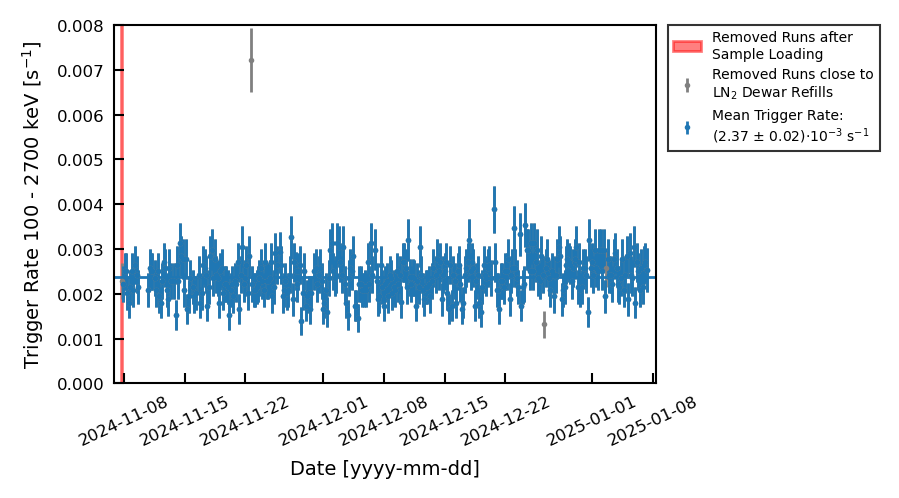

In [28]:
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

mean_trigrate = weighted_mean_plot_clean
std_trigrate = weighted_std_plot_clean
std_trigrate_red = weighted_stdmean_plot_clean
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot.timestamp], df_plot.trigrate, yerr=df_plot.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='gray', 
            label = 'Removed Runs close to\nLN$_2$ Dewar Refills')
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot_clean.timestamp], df_plot_clean.trigrate, yerr=df_plot_clean.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='C0', label='Mean Trigger Rate:\n('+ 
             str(round(1e3*mean_trigrate,2))+' ± '+
             str(round(1e3*std_trigrate_red,2))+')$\cdot10^{-3}$ s$^{-1}$')
plt.axhline(y=mean_trigrate, linewidth=1, color = 'C0')

plt.xlabel(r'Date [yyyy-mm-dd]')
plt.ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]')
plt.xticks(rotation=25)

#plt.ylim(0.0014, 0.0039)
plt.xlim(left = datetime.fromtimestamp(min(np.array(df_plot_clean.timestamp)-2*12*3600)))
plt.xlim(right = datetime.fromtimestamp(max(np.array(df_plot_clean.timestamp)+2*12*3600)))
plt.ylim(0.000, 0.008)

if e_high <= 100:
    plt.yscale('log')

if thr_i_loading >= 0:
    plt.axvspan(datetime.fromtimestamp(df_plot.timestamp[0]-(df_plot.timestamp[1]-df_plot.timestamp[0])/2), 
                datetime.fromtimestamp(df_plot.timestamp[thr_i_loading]+(df_plot.timestamp[thr_i_loading+1]-df_plot.timestamp[thr_i_loading])/2), 
                alpha = 0.5, color = 'red', zorder = -10, label = 'Removed Runs after\nSample Loading')

legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.savefig('trigrate_100_2700_zoom.png', bbox_inches='tight')

plt.show()

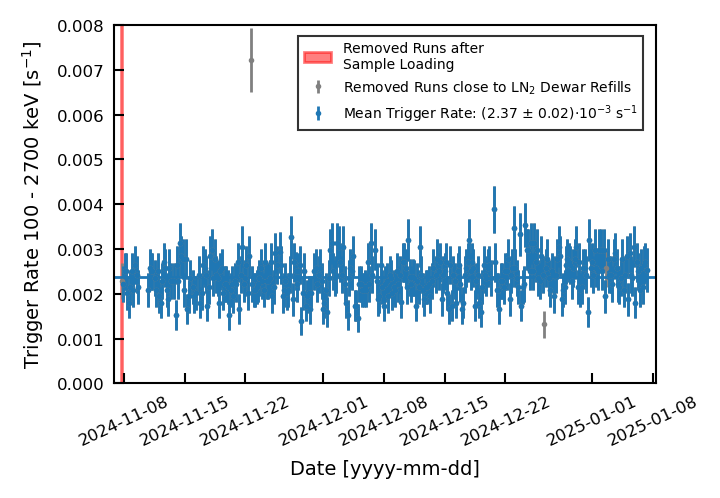

In [29]:
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

mean_trigrate = weighted_mean_plot_clean
std_trigrate = weighted_std_plot_clean
std_trigrate_red = weighted_stdmean_plot_clean
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot.timestamp], df_plot.trigrate, yerr=df_plot.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='gray', 
            label = 'Removed Runs close to LN$_2$ Dewar Refills')
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot_clean.timestamp], df_plot_clean.trigrate, yerr=df_plot_clean.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='C0', label='Mean Trigger Rate: ('+ 
             str(round(1e3*mean_trigrate,2))+' ± '+
             str(round(1e3*std_trigrate_red,2))+')$\cdot10^{-3}$ s$^{-1}$')
plt.axhline(y=mean_trigrate, linewidth=1, color = 'C0')

plt.xlabel(r'Date [yyyy-mm-dd]')
plt.ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]')
plt.xticks(rotation=25)

#plt.ylim(0.0014, 0.0039)
plt.xlim(left = datetime.fromtimestamp(min(np.array(df_plot_clean.timestamp)-2*12*3600)))
plt.xlim(right = datetime.fromtimestamp(max(np.array(df_plot_clean.timestamp)+2*12*3600)))
plt.ylim(0.000, 0.008)

if e_high <= 100:
    plt.yscale('log')

if thr_i_loading >= 0:
    plt.axvspan(datetime.fromtimestamp(df_plot.timestamp[0]-(df_plot.timestamp[1]-df_plot.timestamp[0])/2), 
                datetime.fromtimestamp(df_plot.timestamp[thr_i_loading]+(df_plot.timestamp[thr_i_loading+1]-df_plot.timestamp[thr_i_loading])/2), 
                alpha = 0.5, color = 'red', zorder = -10, label = 'Removed Runs after\nSample Loading')

legend = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.savefig('trigrate_100_2700_zoom_difflegend.png', bbox_inches='tight')

plt.show()

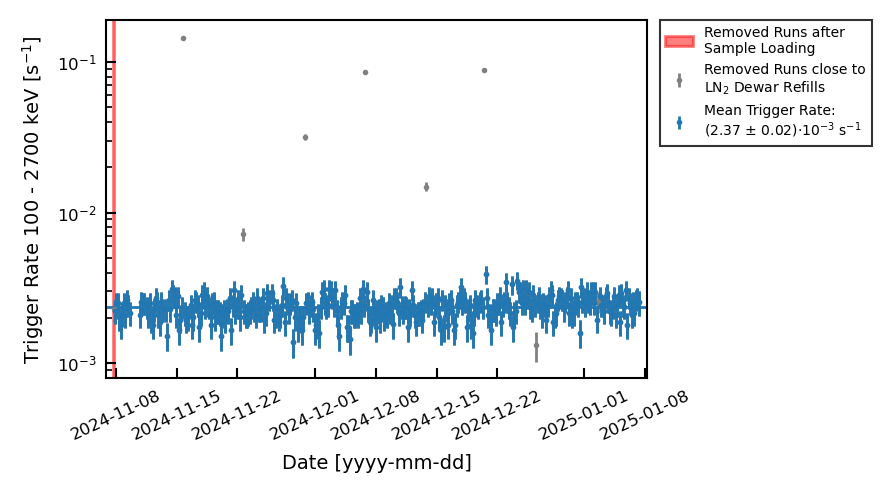

In [30]:
plt.gca().xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))

mean_trigrate = weighted_mean_plot_clean
std_trigrate = weighted_std_plot_clean
std_trigrate_red = weighted_stdmean_plot_clean
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot.timestamp], df_plot.trigrate, yerr=df_plot.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='gray', 
            label = 'Removed Runs close to\nLN$_2$ Dewar Refills')
plt.errorbar([datetime.fromtimestamp(d) for d in df_plot_clean.timestamp], df_plot_clean.trigrate, yerr=df_plot_clean.trigrate_err, 
            fmt='o',ms=1, linewidth=1, color='C0', label='Mean Trigger Rate:\n('+ 
             str(round(1e3*mean_trigrate,2))+' ± '+
             str(round(1e3*std_trigrate_red,2))+')$\cdot10^{-3}$ s$^{-1}$')
plt.axhline(y=mean_trigrate, linewidth=1, color = 'C0')

plt.xlabel(r'Date [yyyy-mm-dd]')
plt.ylabel(r'Trigger Rate '+str(int(e_low))+' - '+str(int(e_high))+' keV [s$^{-1}$]')
plt.xticks(rotation=25)

#plt.ylim(0.0014, 0.0039)
plt.xlim(left = datetime.fromtimestamp(min(np.array(df_plot_clean.timestamp)-2*12*3600)))
plt.xlim(right = datetime.fromtimestamp(max(np.array(df_plot_clean.timestamp)+2*12*3600)))
plt.yscale('log')

if e_high <= 100:
    plt.yscale('log')

if thr_i_loading >= 0:
    plt.axvspan(datetime.fromtimestamp(df_plot.timestamp[0]-(df_plot.timestamp[1]-df_plot.timestamp[0])/2), 
                datetime.fromtimestamp(df_plot.timestamp[thr_i_loading]+(df_plot.timestamp[thr_i_loading+1]-df_plot.timestamp[thr_i_loading])/2), 
                alpha = 0.5, color = 'red', zorder = -10, label = 'Removed Runs after\nSample Loading')

legend = plt.legend(loc=2, bbox_to_anchor=(1.01,1.02), frameon=True, shadow=False, edgecolor='black', fancybox=False)
legend.get_frame().set_linewidth(0.75)

plt.savefig('trigrate_100_2700_log.png', bbox_inches='tight')

plt.show()

In [31]:
print(np.sum(df[df.clean].live_time)/np.sum(df.live_time))
print(1-np.sum(df[df.clean].live_time)/np.sum(df.live_time))

0.9745578344005563
0.025442165599443678


In [32]:
mean_trigrate

0.002374289101952465

In [33]:
## Chi^2
chi2 = np.sum((df_plot_clean.trigrate - mean_trigrate)**2 / (df_plot_clean.trigrate_err)**2)
chi2

345.82718402459903

In [34]:
ddof = len(df_plot_clean)-1
ddof

344

In [35]:
chi2/ddof

1.0053115814668576